# Proyecto de predicciones para CS2

Importamos las librerías que utilizaremos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Limpieza de datos

Cargamos los datos extraidos previamente con web scraping y la clase ``HltvScraper``.

In [2]:
data = "WebScraping/Data/"

df_matches = pd.read_csv(data + "matches_played_by_team.csv")
df_players = pd.read_csv(data + "players_stats.csv")
df_teams   = pd.read_csv(data + "teams_stats_by_map.csv")
df_pistols = pd.read_csv(data + "pistols.csv")
df_ftu     = pd.read_csv(data + "ftu.csv")

Definimos la siguiente función que nos ayudará a limpiar los datos.

In [3]:
def dividir_columna(df: pd.DataFrame, column: str, sep: str, new_names: list) -> pd.DataFrame:
    position = df.columns.get_loc(column)
    columns_created = df.pop(column).str.split(sep, expand=True)
    columns_created.columns = new_names

    for i, col in enumerate(columns_created.columns):
        df.insert(position + i, col, columns_created[col])

    return df

## Limpieza de ``df_matches``

In [4]:
df_matches.head()

,Date,Event,Opponent,Map,Result,W/L,Group,Team
0,19/11/24,Perfect World Shanghai Major 2024 Europe RMR A,SAW,Ancient,13 - 2,W,europa_1,Natus Vincere
1,19/11/24,Perfect World Shanghai Major 2024 Europe RMR A,SAW,Nuke,13 - 10,W,europa_1,Natus Vincere
2,18/11/24,Perfect World Shanghai Major 2024 Europe RMR A,MOUZ,Inferno,7 - 13,L,europa_1,Natus Vincere
3,18/11/24,Perfect World Shanghai Major 2024 Europe RMR A,MOUZ,Dust2,8 - 13,L,europa_1,Natus Vincere
4,18/11/24,Perfect World Shanghai Major 2024 Europe RMR A,MOUZ,Mirage,13 - 4,W,europa_1,Natus Vincere


In [5]:
df_matches.dtypes

Date        object
Event       object
Opponent    object
Map         object
Result      object
W/L         object
Group       object
Team        object
dtype: object

In [6]:
df_matches = dividir_columna(df_matches, "Result", " - ", ["Rounds won", "Rounds lost"])



columns_to_int = ["Rounds won", "Rounds lost"]
columns_to_category = ["Map", "W/L", "Group", "Team"]

for col in columns_to_int:
    df_matches[col] = df_matches[col].astype(int)

for col in columns_to_category:
    df_matches[col] = df_matches[col].astype("category")

df_matches["Date"] = df_matches["Date"].astype("datetime64[ns]")

In [7]:
df_matches = df_matches.drop(["Event", "Group"], axis=1)
col = df_matches.pop("Team")
df_matches.insert(1, "Team", col)
df_matches

,Date,Team,Opponent,Map,Rounds won,Rounds lost,W/L
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,W
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,W
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,L
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,L
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,W
...,...,...,...,...,...,...,...
11455,2024-08-28,DRILLAS,Al-Ittihad,Mirage,13,1,W
11456,2024-08-28,DRILLAS,JiJieHao,Dust2,8,13,L
11457,2024-08-22,DRILLAS,Superfkrs,Anubis,8,13,L
11458,2024-08-21,DRILLAS,Unlucky Much?,Mirage,13,7,W


In [8]:
df_matches = df_matches[df_matches["Map"] != "Overpass"]

teams = df_teams["Team"].unique()
df_matches = df_matches[df_matches["Opponent"].isin(teams)]

In [9]:
df_matches = df_matches.rename({
    "Map": "Map Name",
    "Rounds won": "Result RW",
    "Rounds lost": "Result RL"
}, axis=1)

df_matches["Result Diff"] = df_matches["Result RW"] - df_matches["Result RL"]
df_matches

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,W,11
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,W,3
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,L,-6
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,L,-5
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,W,9
...,...,...,...,...,...,...,...,...
11430,2024-04-10,DRILLAS,GamerLegion,Anubis,13,10,W,3
11437,2024-09-30,DRILLAS,TSM,Nuke,8,13,L,-5
11438,2024-09-30,DRILLAS,TSM,Ancient,11,13,L,-2
11443,2024-09-24,DRILLAS,Passion UA,Mirage,16,14,W,2


In [10]:
df_matches['W/L']= pd.Categorical(df_matches['W/L']).codes
df_matches

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,1,11
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,1,3
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,0,-6
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,0,-5
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,1,9
...,...,...,...,...,...,...,...,...
11430,2024-04-10,DRILLAS,GamerLegion,Anubis,13,10,1,3
11437,2024-09-30,DRILLAS,TSM,Nuke,8,13,0,-5
11438,2024-09-30,DRILLAS,TSM,Ancient,11,13,0,-2
11443,2024-09-24,DRILLAS,Passion UA,Mirage,16,14,1,2


## Limpieza de ``df_players``

In [11]:
df_players.head()

,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group,Team,Map Name
0,392,473,0.83,0.54,296,-81,72,86,0.84,0.97,...,242,1,79,55,16,5,aleksib,europa_1,Natus Vincere,Ancient
1,509,490,1.04,0.70,338,19,101,108,0.94,1.12,...,401,6,10,86,4,3,im,europa_1,Natus Vincere,Ancient
2,529,450,1.18,0.73,361,79,74,45,1.64,1.07,...,419,2,22,84,3,1,b1t,europa_1,Natus Vincere,Ancient
3,540,454,1.19,0.75,355,86,75,60,1.25,1.05,...,437,5,23,72,3,2,jl,europa_1,Natus Vincere,Ancient
4,505,419,1.21,0.70,344,86,65,37,1.76,1.03,...,234,164,14,92,3,1,w0nderful,europa_1,Natus Vincere,Ancient


In [12]:
df_players.dtypes

Kills                                  int64
Deaths                                 int64
Kill / Death                         float64
Kill / Round                         float64
Rounds with kills                      int64
Kill - Death difference                int64
Total opening kills                    int64
Total opening deaths                   int64
Opening kill ratio                   float64
Opening kill rating                  float64
Team win percent after first kill     object
First kill in won rounds              object
0 kill rounds                          int64
1 kill rounds                          int64
2 kill rounds                          int64
3 kill rounds                          int64
4 kill rounds                          int64
5 kill rounds                          int64
Rifle kills                            int64
Sniper kills                           int64
SMG kills                              int64
Pistol kills                           int64
Grenade   

In [13]:
columns_to_float = ["Team win percent after first kill", "First kill in won rounds"]
columns_to_category = ["Player", "Group", "Team", "Map Name"]

for col in columns_to_float:
    df_players[col] = df_players[col].str.strip("%").astype(float)

for col in columns_to_category:
    df_players[col] = df_players[col].astype("category")

In [14]:
df_players.isna().sum()

Kills                                0
Deaths                               0
Kill / Death                         0
Kill / Round                         0
Rounds with kills                    0
Kill - Death difference              0
Total opening kills                  0
Total opening deaths                 0
Opening kill ratio                   0
Opening kill rating                  0
Team win percent after first kill    2
First kill in won rounds             0
0 kill rounds                        0
1 kill rounds                        0
2 kill rounds                        0
3 kill rounds                        0
4 kill rounds                        0
5 kill rounds                        0
Rifle kills                          0
Sniper kills                         0
SMG kills                            0
Pistol kills                         0
Grenade                              0
Other                                0
Player                               0
Group                    

In [15]:
df_players["Team win percent after first kill"] = df_players["Team win percent after first kill"].fillna(0)

In [16]:
df_dups = df_players.iloc[:, :-4]
df_dups = df_dups[df_dups.duplicated(keep=False)]
df_dups


,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,2 kill rounds,3 kill rounds,4 kill rounds,5 kill rounds,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other
5,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1841,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1865,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1867,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_players = df_players.drop(index=df_dups.index)

In [18]:
df_players.shape

(1786, 28)

## Limpieza de ``df_teams``

In [19]:
df_teams.head()

,Times played,Wins / draws / losses,Total rounds played,Rounds won,Win percent,Pistol rounds,Pistol rounds won,Pistol round win percent,CT round win percent,T round win percent,Group,Team,Map Name
0,34,22 / 0 / 12,724,390,64.7%,68,38,55.9%,55.1%,52.6%,europa_1,Natus Vincere,Ancient
1,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%,europa_1,Vitality,Ancient
2,23,14 / 0 / 9,513,280,60.9%,46,28,60.9%,56.4%,52.9%,europa_1,MOUZ,Ancient
3,33,21 / 0 / 12,752,409,63.6%,66,40,60.6%,53.8%,54.9%,europa_1,FaZe,Ancient
4,22,8 / 0 / 14,479,224,36.4%,44,23,52.3%,50.4%,42.3%,europa_1,Falcons,Ancient


In [20]:
df_dups = df_teams.iloc[:, :-3]
df_dups = df_dups[df_dups.duplicated(keep=False)]
df_dups

,Times played,Wins / draws / losses,Total rounds played,Rounds won,Win percent,Pistol rounds,Pistol rounds won,Pistol round win percent,CT round win percent,T round win percent
1,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
58,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
77,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
103,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
183,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
185,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
194,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
213,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
222,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
238,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%


In [21]:
df_teams = df_teams.drop(index=df_dups.index)

In [22]:
df_teams = dividir_columna(df_teams, "Wins / draws / losses", " / ", ["Wins", "Draws", "Losses"])

columns_to_int = ["Wins", "Draws", "Losses"]
columns_to_float = ["Win percent", "Pistol round win percent", "CT round win percent", "T round win percent"]
columns_to_category = ["Group", "Team", "Map Name"]

for col in columns_to_int:
    df_teams[col] = df_teams[col].astype(int)

for col in columns_to_float:
    df_teams[col] = df_teams[col].str.strip("%").astype(float)

for col in columns_to_category:
    df_teams[col] = df_teams[col].astype("category")

In [23]:
df_teams = df_teams.drop("Draws", axis=1)

df_teams = df_teams.rename(columns={
    "Win percent": "Win%",
    "Pistol round win percent": "Pistol round win%",
    "CT round win percent": "CT round win%",
    "T round win percent": "T round win%"
})

In [24]:
for col in ['Map Name', 'Team', 'Group']:
    col_pop = df_teams.pop(col)
    df_teams.insert(0, col, col_pop)
    df_teams

## Limpieza de ``df_pistols`` y ``df_ftu``

Limpiaremos los datos con el fin de añadirlos a ``df_teams``

In [25]:
df_general_stats = pd.merge(df_pistols, df_ftu, how="outer", on=["Team", "Map Name"])

# Se filtran los equipos participantes
teams = df_teams["Team"].unique()
df_general_stats = df_general_stats[df_general_stats["Team"].isin(teams)]
df_general_stats = df_general_stats.reset_index(drop=True)

In [26]:
df_general_stats.head()

,Team,Maps_x,Won - Lost,Pistol win %,Round 2 conv,Round 2 break,Map Name,Maps_y,RW%,OpK,MultiK,5v4%,4v5%,Traded%,ADR,FA
0,3DMAX,67,63 - 71,47.0%,85.7%,19.7%,Ancient,67,47.9%,48.7%,0.80,71.5%,25.5%,21.6%,27.4,0.28
1,3DMAX,74,78 - 70,52.7%,88.5%,18.6%,Anubis,74,53.6%,51.3%,0.84,74.9%,31.4%,23.7%,26.4,0.26
2,3DMAX,29,26 - 32,44.8%,76.9%,21.9%,Dust2,29,51.6%,52.9%,0.82,73.5%,27.1%,21.3%,24.4,0.33
3,3DMAX,48,56 - 40,58.3%,85.7%,5.0%,Inferno,48,54.8%,52.8%,0.83,75.2%,32.1%,23.1%,40.7,0.27
4,3DMAX,2,0 - 4,0.0%,-,25.0%,Mirage,2,18.8%,22.6%,0.56,42.9%,12.0%,10.3%,15.2,0.16


In [27]:
df_general_stats = df_general_stats.replace("-", 0)

In [28]:
df_general_stats = dividir_columna(df_general_stats, "Won - Lost", " - ", ["Won", "Pistol rounds lost"])
df_general_stats = df_general_stats.drop(["Maps_x", "Maps_y", "Won", "Pistol win %"], axis=1)
df_general_stats = df_general_stats.rename(columns={
    "RW%": "Round win%",
    "OpK": "Opening duel won%",
    "5v4%": "Win 5v4%",
    "4v5%": "Win 4v5%",
    "Traded%": "Death traded%",
    "ADR": "Damage w/ utility",
    "FA": "Flash assists"
})

In [29]:
columns_to_int = ["Pistol rounds lost"]
columns_to_float = ["Round 2 conv", "Round 2 break", "Round win%", "Opening duel won%", "Win 5v4%", "Win 4v5%", "Death traded%"]
columns_to_category = ["Team", "Map Name"]

for col in columns_to_int:
    df_general_stats[col] = df_general_stats[col].astype(int)

for col in columns_to_float:
    df_general_stats[col] = df_general_stats[col].str.strip("%").astype(float)

for col in columns_to_category:
    df_general_stats[col] = df_general_stats[col].astype("category")

In [30]:
df_teams = pd.merge(df_teams, df_general_stats, how="left", on=["Team", "Map Name"])

## Visualización de los 3 DF

In [31]:
df_matches.head()

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,1,11
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,1,3
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,0,-6
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,0,-5
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,1,9


In [32]:
df_players.head()

,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group,Team,Map Name
0,392,473,0.83,0.54,296,-81,72,86,0.84,0.97,...,242,1,79,55,16,5,aleksib,europa_1,Natus Vincere,Ancient
1,509,490,1.04,0.70,338,19,101,108,0.94,1.12,...,401,6,10,86,4,3,im,europa_1,Natus Vincere,Ancient
2,529,450,1.18,0.73,361,79,74,45,1.64,1.07,...,419,2,22,84,3,1,b1t,europa_1,Natus Vincere,Ancient
3,540,454,1.19,0.75,355,86,75,60,1.25,1.05,...,437,5,23,72,3,2,jl,europa_1,Natus Vincere,Ancient
4,505,419,1.21,0.70,344,86,65,37,1.76,1.03,...,234,164,14,92,3,1,w0nderful,europa_1,Natus Vincere,Ancient


In [33]:
df_teams.head()

,Group,Team,Map Name,Times played,Wins,Losses,Total rounds played,Rounds won,Win%,Pistol rounds,...,Round 2 conv,Round 2 break,Round win%,Opening duel won%,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists
0,europa_1,Natus Vincere,Ancient,34,22,12,724,390,64.7,68,...,94.7,10.0,53.9,53.5,0.81,74.4,30.3,19.9,20.9,0.27
1,europa_1,MOUZ,Ancient,23,14,9,513,280,60.9,46,...,96.4,11.1,54.6,54.2,0.87,74.8,30.6,22.9,28.0,0.34
2,europa_1,FaZe,Ancient,33,21,12,752,409,63.6,66,...,90.0,15.4,54.4,51.3,0.86,73.8,34.1,20.4,24.2,0.23
3,europa_1,Falcons,Ancient,22,8,14,479,224,36.4,44,...,87.0,23.8,46.8,45.9,0.79,70.8,26.5,16.9,26.0,0.22
4,europa_1,BetBoom,Ancient,47,28,19,978,506,59.6,94,...,91.3,12.5,51.7,46.7,0.80,74.8,31.5,21.0,23.1,0.18


# 2. Exploración de datos (EDA)

## Win% y Player Stats

Queremos entender como se relacionan las estadísticas de los jugadores de un equipo en un cierto mapa, con el porcentaje de victorias en él. 

In [34]:
stats_win = pd.merge(df_players, df_teams[["Win%", "Team", "Map Name"]], how="left", on=["Team", "Map Name"])
stats_win = stats_win.drop(["Player", "Group", "Team"], axis=1)
stats_win = stats_win.dropna()

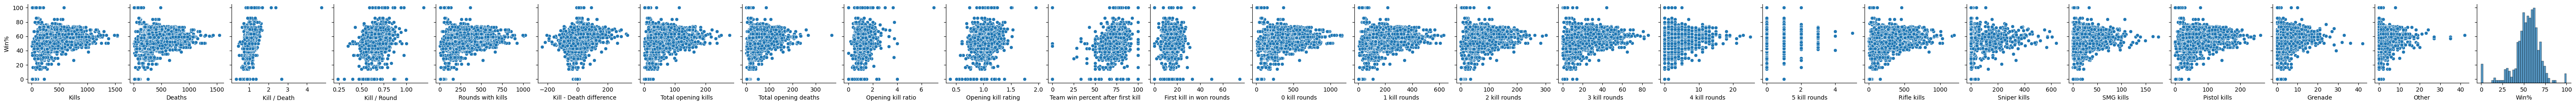

In [35]:
sns.pairplot(stats_win, y_vars="Win%")

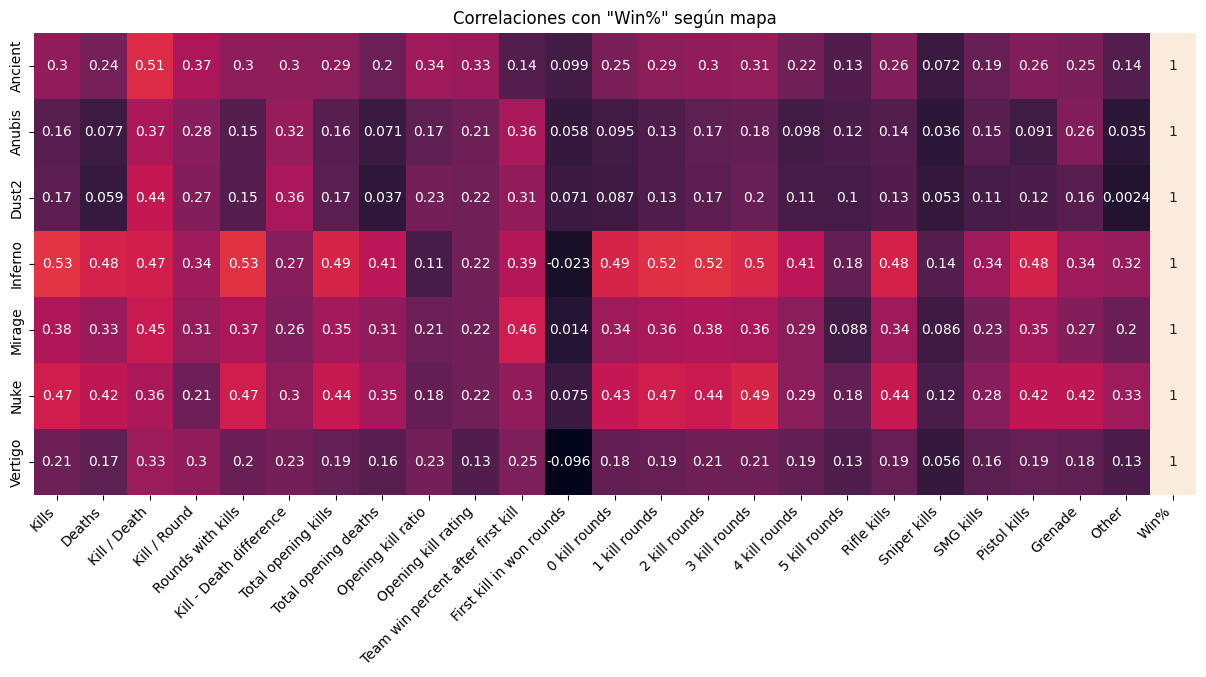

In [36]:
maps = ['Ancient', 'Anubis', 'Dust2', 'Inferno', 'Mirage', 'Nuke', 'Vertigo']
variables = list(stats_win.columns)
variables.remove("Map Name")

corr = []
for map_name in maps:
    filtro = stats_win[stats_win["Map Name"] == map_name]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa')

plt.xticks(rotation=45, ha='right')

plt.show()

Abrá algún cambio si filtramos ``Win percent`` a valores en (0, 100).

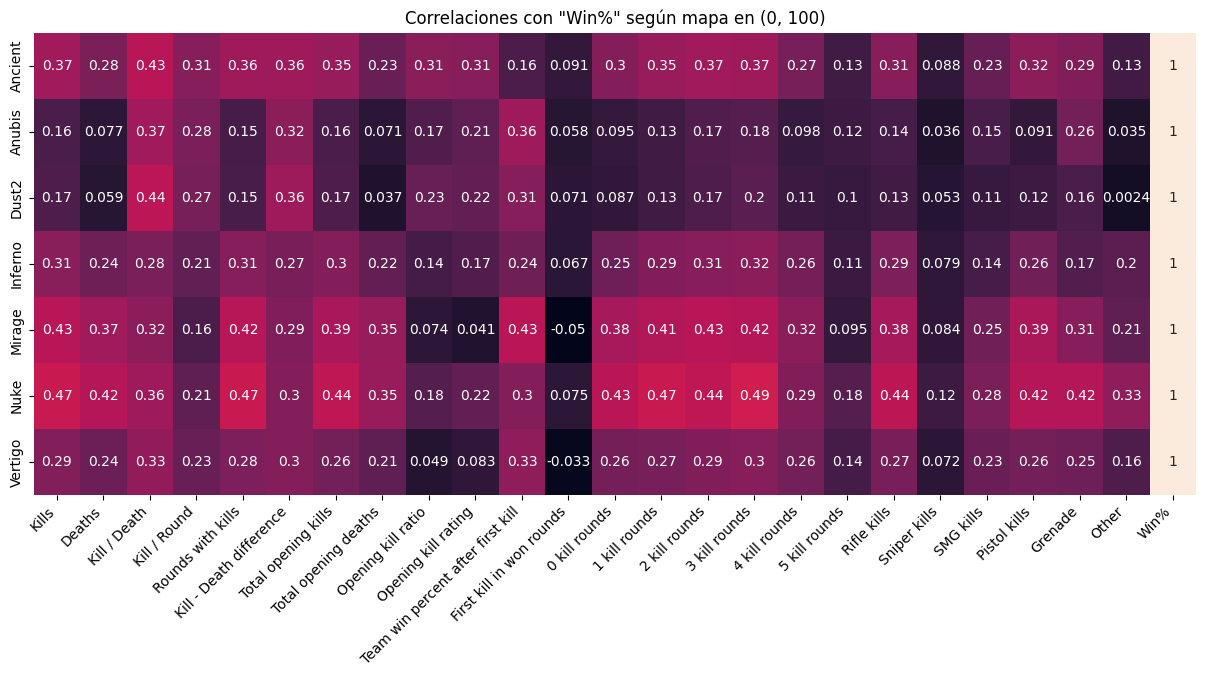

In [37]:
corr = []
for map_name in maps:
    filtro = stats_win[stats_win["Map Name"] == map_name]
    filtro = filtro[filtro["Win%"] != 0]
    filtro = filtro[filtro["Win%"] != 100]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa en (0, 100)')

plt.xticks(rotation=45, ha='right')

plt.show()

En los equipos, los jugadores tienen asignados diferentes roles. Uno de ellos es el "awper", caracterizado ser el jugador que lleva el arma "AWP" en las rondas. 

Definimos a un awper a aquellos jugadores con más de 150 Sniper kills. Veamos si hay algún cambio en las correlaciones, sobre todo en la variable ``Sniper kills``.

In [38]:
stats_win["Sniper kills"].quantile(.9)

np.float64(172.9000000000001)

<Axes: ylabel='Sniper kills'>

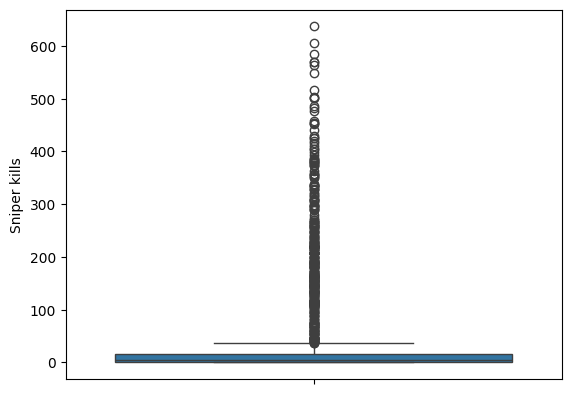

In [39]:
sns.boxplot(stats_win["Sniper kills"])

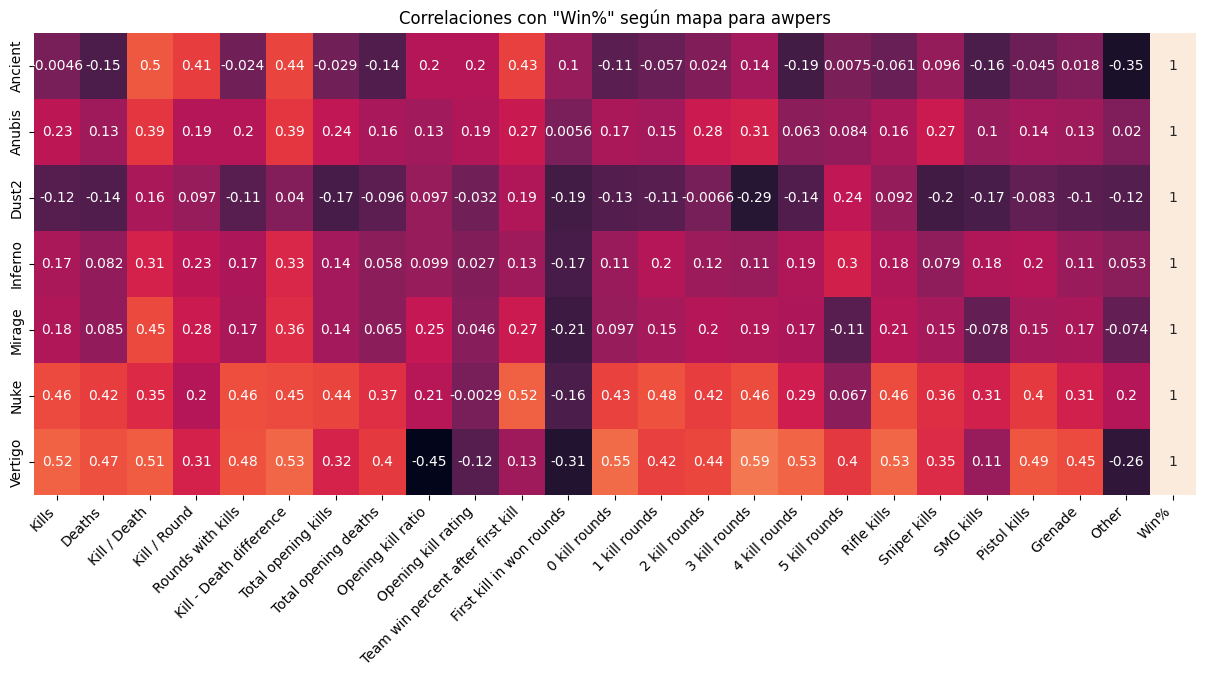

In [40]:
corr = []
for map_name in maps:
    filtro = stats_win[stats_win["Map Name"] == map_name]
    filtro = filtro[filtro["Sniper kills"] >= 150]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa para awpers')

plt.xticks(rotation=45, ha='right')

plt.show()

Vemos que los awpers tiene más impacto en los mapas de Nuke y Vertigo.

## Win% y Team Stats

In [41]:
df_teams.head()

,Group,Team,Map Name,Times played,Wins,Losses,Total rounds played,Rounds won,Win%,Pistol rounds,...,Round 2 conv,Round 2 break,Round win%,Opening duel won%,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists
0,europa_1,Natus Vincere,Ancient,34,22,12,724,390,64.7,68,...,94.7,10.0,53.9,53.5,0.81,74.4,30.3,19.9,20.9,0.27
1,europa_1,MOUZ,Ancient,23,14,9,513,280,60.9,46,...,96.4,11.1,54.6,54.2,0.87,74.8,30.6,22.9,28.0,0.34
2,europa_1,FaZe,Ancient,33,21,12,752,409,63.6,66,...,90.0,15.4,54.4,51.3,0.86,73.8,34.1,20.4,24.2,0.23
3,europa_1,Falcons,Ancient,22,8,14,479,224,36.4,44,...,87.0,23.8,46.8,45.9,0.79,70.8,26.5,16.9,26.0,0.22
4,europa_1,BetBoom,Ancient,47,28,19,978,506,59.6,94,...,91.3,12.5,51.7,46.7,0.80,74.8,31.5,21.0,23.1,0.18


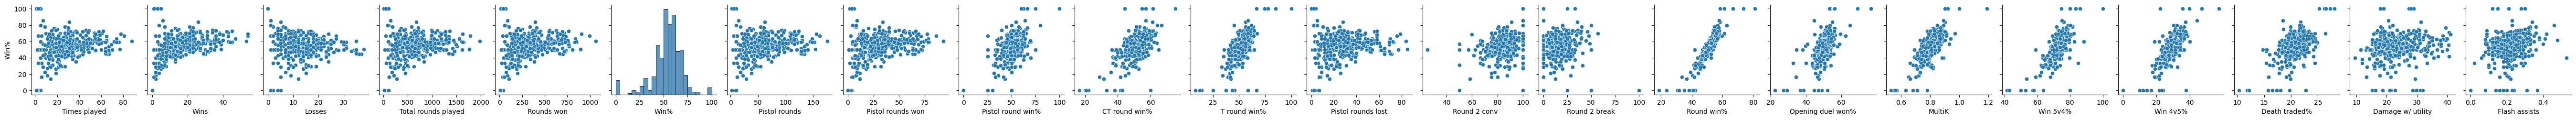

In [42]:
sns.pairplot(df_teams, y_vars="Win%")

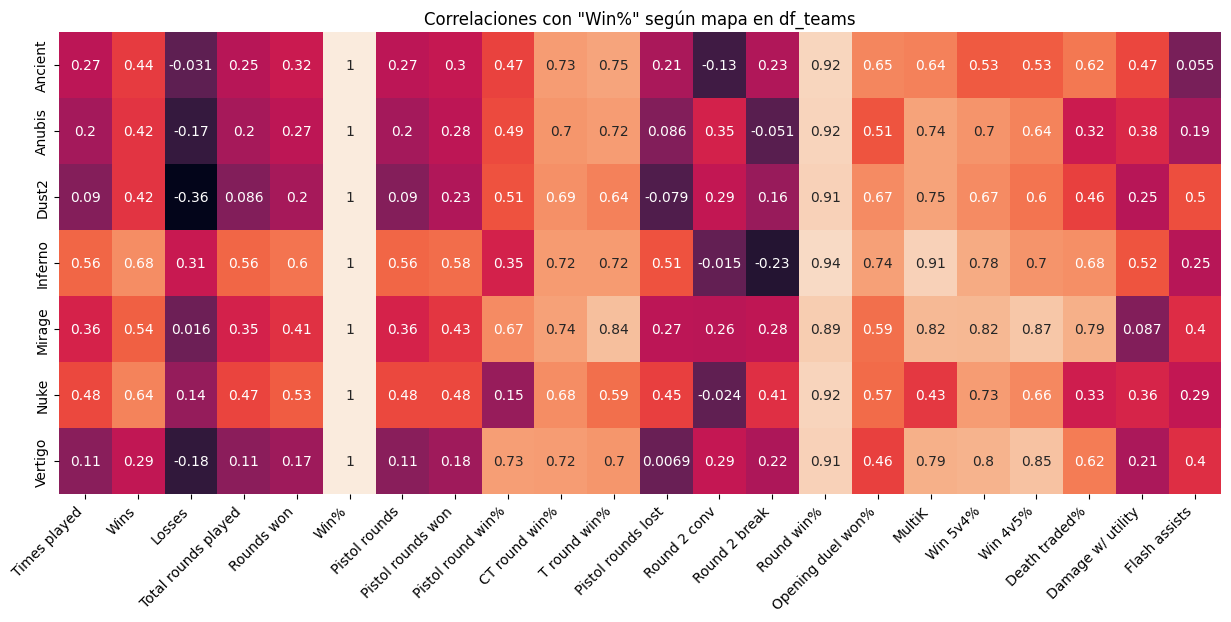

In [43]:
variables = list(df_teams.columns)
variables.remove("Team")
variables.remove("Group")
variables.remove("Map Name")

corr = []
for map_name in maps:
    filtro = df_teams[df_teams["Map Name"] == map_name]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa en df_teams')

plt.xticks(rotation=45, ha='right')
plt.show()

# 3. Modelos de predicción

## Métricas de equipo

Dadas las observaciones vistas en el EDA, integraremos las stats de los jugadores a DataFrame ``df_teams``, de manera de tener los datos más representativos en de los jugadores de un equipo en todos los mapas.

Vimos que hay ciertas stats que se correlacionan más que otras con el Win% de su equipo. Para integrarlas utilizaremos árboles de decisiones, pero no tan solo uno y arriesgarnos a producir un overfitting o a obtener malos resultados por el ruido, en cambio usaremos varios de ellos utilizando ``RandomForestRegressor`` que finalmente nos dirá cuales stats de los jugadores tienen más peso en el porcentaje de victorias del equipo.

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Separar variables predictoras (X) y variable objetivo (y)
X = stats_win.drop(columns=['Win%', 'Map Name'])
y = stats_win['Win%']

# Normalización con StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Crear modelo Random Forest para regresión
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Validación cruzada con RMSE
scores = cross_val_score(rf_model, X_sc, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

rmse_scores = -scores

print("RMSE por partición:", rmse_scores)
print("Promedio de RMSE:", rmse_scores.mean())
print("Desviación estándar de RMSE:", rmse_scores.std())

RMSE por partición: [10.12047566 10.80118815 14.39159523 11.52437033 14.68540045]
Promedio de RMSE: 12.304605962801546
Desviación estándar de RMSE: 1.8795299687947835


In [45]:
def comparacion_stats_por_mapa(df: pd.DataFrame, titulo: str) -> pd.DataFrame:
    feature_importance_df = pd.DataFrame()
    for map_name in maps:
        filtro = df[df["Map Name"] == map_name]

        X = filtro.drop(columns=['Win%', 'Map Name'])
        y = filtro['Win%']

        rf_model.fit(X, y)

        # Importancia de características
        feature_importance_map = pd.DataFrame(rf_model.feature_importances_, columns=[map_name], index=X.columns)

        feature_importance_df = pd.concat([feature_importance_df, feature_importance_map], axis=1)

    df_melted = feature_importance_df.T.reset_index().melt(id_vars='index', var_name='Columna', value_name='Valor')
    df_melted.rename(columns={'index': 'Fila'}, inplace=True)
    df_melted

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melted, x='Columna', y='Valor', hue='Fila', palette='Set1')

    plt.title(titulo, fontsize=16)
    plt.ylabel('Peso')
    plt.xlabel('Stat')
    plt.legend(title='Filas', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()

    return feature_importance_df.T

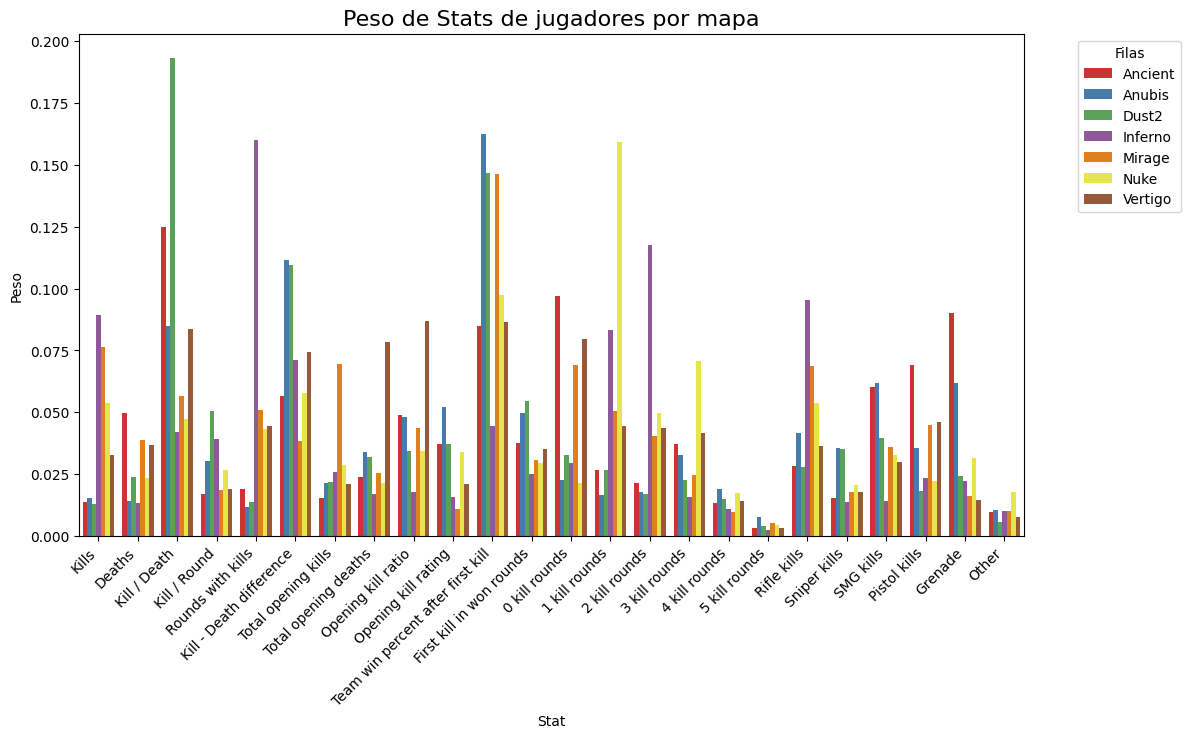

In [46]:
a = comparacion_stats_por_mapa(stats_win, "Peso de Stats de jugadores por mapa")

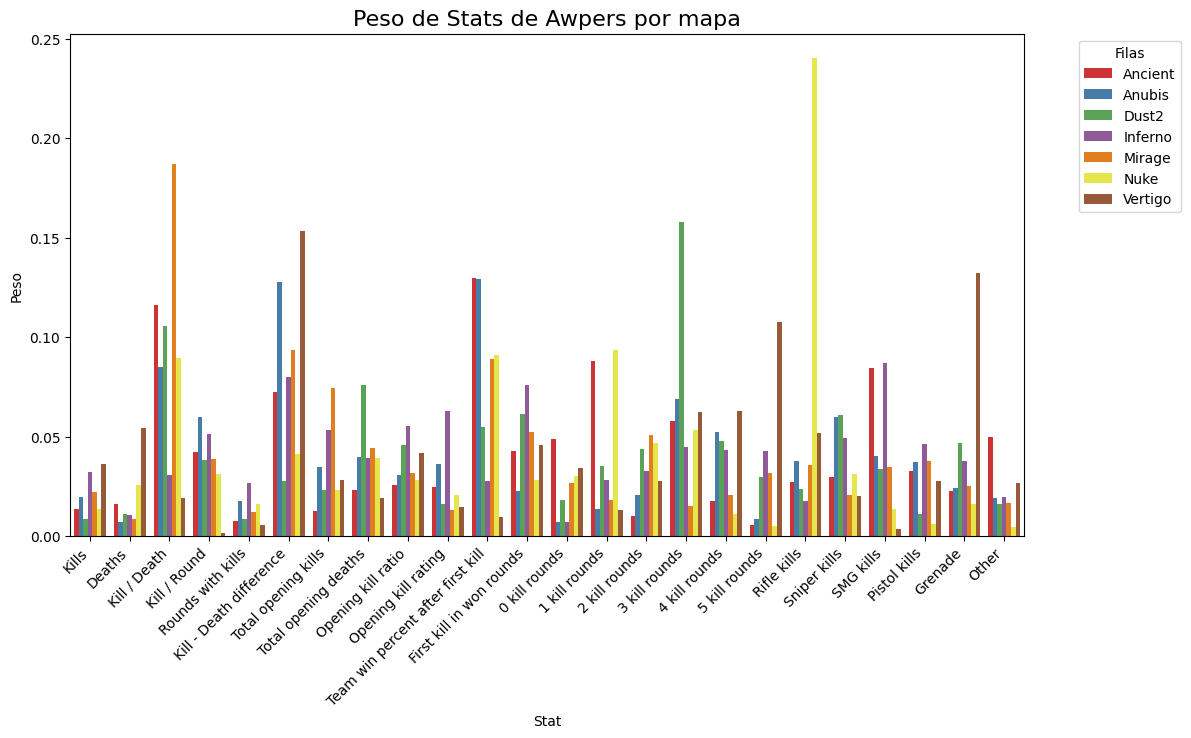

In [47]:
stats_awpers = stats_win[stats_win["Sniper kills"] >= 150]
peso_awpers = comparacion_stats_por_mapa(stats_awpers, "Peso de Stats de Awpers por mapa")

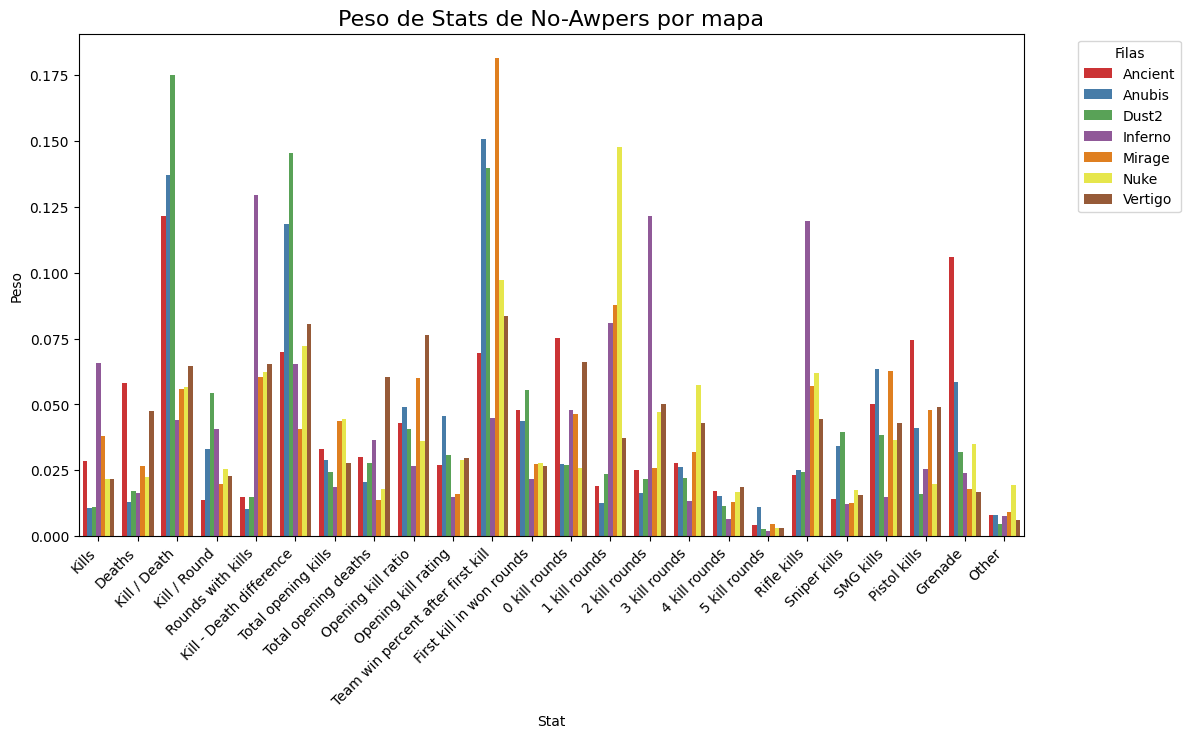

In [48]:
stats_not_awpers = stats_win[stats_win["Sniper kills"] <= 150]
pesos_not_awpers = comparacion_stats_por_mapa(stats_not_awpers, "Peso de Stats de No-Awpers por mapa")

Para integrar los datos de manera a ``df_team`` vamos a estandarizar los datos y luego calcular el valor del jugardor en 4 grupos diferentes, para así promediarlo con el de sus compañeros de equipo. 

In [49]:
df_players

,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group,Team,Map Name
0,392,473,0.83,0.54,296,-81,72,86,0.84,0.97,...,242,1,79,55,16,5,aleksib,europa_1,Natus Vincere,Ancient
1,509,490,1.04,0.70,338,19,101,108,0.94,1.12,...,401,6,10,86,4,3,im,europa_1,Natus Vincere,Ancient
2,529,450,1.18,0.73,361,79,74,45,1.64,1.07,...,419,2,22,84,3,1,b1t,europa_1,Natus Vincere,Ancient
3,540,454,1.19,0.75,355,86,75,60,1.25,1.05,...,437,5,23,72,3,2,jl,europa_1,Natus Vincere,Ancient
4,505,419,1.21,0.70,344,86,65,37,1.76,1.03,...,234,164,14,92,3,1,w0nderful,europa_1,Natus Vincere,Ancient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,18,15,1.20,0.86,13,3,3,0,0.00,1.38,...,13,0,3,2,0,0,salo-mux,asia_rmr,GR,Vertigo
1862,5,16,0.31,0.24,5,-11,1,3,0.33,0.67,...,2,2,0,1,0,0,weqt2,asia_rmr,GR,Vertigo
1863,12,14,0.86,0.57,7,-2,0,2,0.00,0.51,...,8,0,0,3,2,1,mediocrity,asia_rmr,GR,Vertigo
1864,15,17,0.88,0.71,7,-2,4,3,1.33,1.38,...,11,0,0,2,2,0,runnin,asia_rmr,GR,Vertigo


In [50]:
from sklearn.preprocessing import StandardScaler

awpers = df_players[df_players["Sniper kills"] >= 150]
non_awpers = df_players[df_players["Sniper kills"] < 150]

def normalizar_stats(df: pd.DataFrame) -> pd.DataFrame:
    numeric_columns = df.select_dtypes(include=["number"])
    non_numeric_columns = df.select_dtypes(exclude=["number"])

    scaler = StandardScaler()
    numeric_columns_normalized = scaler.fit_transform(numeric_columns)

    stats_normalized = non_numeric_columns.copy()
    stats_normalized[numeric_columns.columns] = numeric_columns_normalized
    return stats_normalized

awpers_normalized     = normalizar_stats(awpers)
non_awpers_normalized = normalizar_stats(non_awpers)

In [51]:
Overall_stats = ['Kills', 'Deaths', 'Kill / Death', 'Kill / Round', 'Rounds with kills', 'Kill - Death difference']
Opening_stats = ['Total opening kills', 'Total opening deaths', 'Opening kill ratio', 'Opening kill rating', 'Team win percent after first kill', 'First kill in won rounds']
Round_stats = ['0 kill rounds', '1 kill rounds', '2 kill rounds', '3 kill rounds', '4 kill rounds', '5 kill rounds']
Weapon_stats = ['Rifle kills', 'Sniper kills', 'SMG kills', 'Pistol kills', 'Grenade', 'Other']

def stats_with_weight(df: pd.DataFrame) -> pd.DataFrame:
    df_final = pd.DataFrame()
    for map_name in maps:
        stats_map = df[df["Map Name"] == map_name].copy()
        weight_map = peso_awpers.loc[map_name]

        stats_map["Overall Stats"] = stats_map[Overall_stats].dot(weight_map[Overall_stats])
        stats_map["Opening Stats"] = stats_map[Opening_stats].dot(weight_map[Opening_stats])
        stats_map["Round Stats"] = stats_map[Round_stats].dot(weight_map[Round_stats])
        stats_map["Weapon Stats"] = stats_map[Weapon_stats].dot(weight_map[Weapon_stats])

        df_final = pd.concat([df_final, stats_map])
    
    return df_final

awpers = stats_with_weight(awpers_normalized)
non_awpers = stats_with_weight(non_awpers_normalized)

In [52]:
a = pd.concat([awpers, non_awpers])
a = a.groupby(["Team", "Map Name"], observed=False)[["Overall Stats", "Opening Stats", "Round Stats", "Weapon Stats"]].mean()

In [53]:
df_teams = df_teams.merge(a.reset_index(), on=['Team', 'Map Name'], how='inner')
df_teams

,Group,Team,Map Name,Times played,Wins,Losses,Total rounds played,Rounds won,Win%,Pistol rounds,...,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists,Overall Stats,Opening Stats,Round Stats,Weapon Stats
0,europa_1,Natus Vincere,Ancient,34,22,12,724,390,64.7,68,...,0.81,74.4,30.3,19.9,20.9,0.27,0.047609,0.028320,0.043849,0.003501
1,europa_1,MOUZ,Ancient,23,14,9,513,280,60.9,46,...,0.87,74.8,30.6,22.9,28.0,0.34,0.067904,0.053050,-0.045235,-0.034949
2,europa_1,FaZe,Ancient,33,21,12,752,409,63.6,66,...,0.86,73.8,34.1,20.4,24.2,0.23,0.093815,0.023704,0.074244,0.068356
3,europa_1,Falcons,Ancient,22,8,14,479,224,36.4,44,...,0.79,70.8,26.5,16.9,26.0,0.22,-0.130443,-0.265945,-0.195829,-0.183053
4,europa_1,BetBoom,Ancient,47,28,19,978,506,59.6,94,...,0.80,74.8,31.5,21.0,23.1,0.18,-0.067155,0.019008,0.154079,0.146061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,asia_rmr,FlyQuest,Vertigo,11,7,4,245,139,63.6,22,...,0.94,73.7,36.6,22.2,40.1,0.41,0.096782,0.024479,0.011461,0.057156
359,asia_rmr,Lynn Vision,Vertigo,7,2,5,150,72,28.6,14,...,0.81,63.2,32.4,20.5,21.8,0.20,-0.167931,-0.081172,-0.289326,-0.235570
360,asia_rmr,Rare Atom,Vertigo,12,7,5,254,134,58.3,24,...,0.85,74.4,31.8,19.2,31.1,0.22,-0.120208,-0.041093,-0.212200,-0.218103
361,asia_rmr,TALON,Vertigo,8,4,4,180,92,50.0,16,...,0.81,69.9,31.0,24.2,28.7,0.24,0.046649,0.043056,-0.036773,-0.064031


In [54]:
from scipy.stats import pearsonr

c1 = pearsonr(df_teams["Overall Stats"], df_teams["Win%"])
c2 = pearsonr(df_teams["Opening Stats"], df_teams["Win%"])
c3 = pearsonr(df_teams["Round Stats"], df_teams["Win%"])
c4 = pearsonr(df_teams["Weapon Stats"], df_teams["Win%"])

print(f"Correlación entre métrica del equipo y victorias: {c1[0]}, {c2[0]}, {c3[0]}, {c4[0]}")

Correlación entre métrica del equipo y victorias: 0.6805074094635178, 0.43468885663366996, 0.2919020829406075, 0.31531453078512706


## Prueba de Modelos

Como nuestro objetivo es predecir quien ganará un enfrentamiento entre dos equipos, hay que entrenar un modelo que, al pasarle dos equipos, nos de la probabilidad de que un equipo le gane al otro para cada uno de los 7 mapas.

In [55]:
df_complete = pd.merge(df_matches, df_teams, how="left", left_on=["Team", "Map Name"], right_on=["Team", "Map Name"])
df_complete = pd.merge(df_complete, df_teams, how="left", left_on=["Opponent", "Map Name"], right_on=["Team", "Map Name"])

df_complete = df_complete.drop(["Team_y"], axis=1)
df_complete = df_complete.rename({
    "Opponent": "Team_y"
}, axis=1)

In [56]:
maps_encoded = pd.get_dummies(df_complete['Map Name'], prefix='Map')
df = pd.concat([df_complete, maps_encoded], axis=1)
df = df.drop(columns=['Map Name'])
df

,Date,Team_x,Team_y,Result RW,Result RL,W/L,Result Diff,Group_x,Times played_x,Wins_x,...,Opening Stats_y,Round Stats_y,Weapon Stats_y,Map_Ancient,Map_Anubis,Map_Dust2,Map_Inferno,Map_Mirage,Map_Nuke,Map_Vertigo
0,2024-11-19,Natus Vincere,SAW,13,2,1,11,europa_1,34.0,22.0,...,0.006640,0.123655,0.087460,True,False,False,False,False,False,False
1,2024-11-19,Natus Vincere,SAW,13,10,1,3,europa_1,31.0,16.0,...,0.130764,0.312636,0.387372,False,False,False,False,False,True,False
2,2024-11-18,Natus Vincere,MOUZ,7,13,0,-6,europa_1,25.0,14.0,...,-0.059601,-0.064460,-0.101865,False,False,False,True,False,False,False
3,2024-11-18,Natus Vincere,MOUZ,8,13,0,-5,europa_1,17.0,13.0,...,-0.030939,-0.243586,-0.073067,False,False,True,False,False,False,False
4,2024-11-18,Natus Vincere,MOUZ,13,4,1,9,europa_1,38.0,27.0,...,0.056605,0.008718,-0.031685,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5861,2024-04-10,DRILLAS,GamerLegion,13,10,1,3,NaN,NaN,NaN,...,-0.043108,0.032285,0.015482,False,True,False,False,False,False,False
5862,2024-09-30,DRILLAS,TSM,8,13,0,-5,NaN,NaN,NaN,...,-0.004316,0.127765,0.157727,False,False,False,False,False,True,False
5863,2024-09-30,DRILLAS,TSM,11,13,0,-2,NaN,NaN,NaN,...,-0.052193,0.136814,0.098408,True,False,False,False,False,False,False
5864,2024-09-24,DRILLAS,Passion UA,16,14,1,2,NaN,NaN,NaN,...,0.320423,0.395987,0.374344,False,False,False,False,True,False,False


In [57]:
from sklearn.preprocessing import StandardScaler

df = df.drop(columns=["Date", "Team_x", "Team_y", "Result RW", "Result RL", "Group_x", "Group_y"])
df = df.dropna()

team_stats_columns = df.columns[2:24]
team_stats_columns = team_stats_columns.append(df.columns[28:-11])

scaler = StandardScaler()
df[team_stats_columns] = scaler.fit_transform(df[team_stats_columns])

Función para ver la matriz de confución y algunas métricas importantes

In [58]:
from sklearn import metrics

def metricas_importante(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt="")
    plt.ylabel('Observado')
    plt.xlabel('Predicción')
    plt.title('Matriz de Confusión')

    rmse      = metrics.root_mean_squared_error(y_test, y_pred)
    accuracy  = metrics.accuracy_score(y_test, y_pred)
    recall    = metrics.recall_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    fscore    = metrics.f1_score(y_test, y_pred)

    print(f'RMSE:      {rmse:.2f}')
    print(f'Accuracy:  {accuracy:.2f}')
    print(f'Recall:    {recall:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F score:   {fscore:.2f}')

    report0 = metrics.classification_report(y_test, y_pred)
    print(report0)

### Regresión Logística

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['W/L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar el modelo
lr_model = LogisticRegression(tol=1e-6, max_iter=100000,penalty='l1', solver='liblinear',C=0.03393221771895328)
lr_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

Accuracy: 0.638
ROC AUC: 0.689


In [60]:
# Logistic v2

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['W/L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar el modelo

best_acc = 0
# Probar diferentes parámetros c, desde 10**-2 hasta 10**2, probaremos 20 c diferentes
for c in np.logspace(-2,2,20):

    lr_model = LogisticRegression(tol=1e-6, max_iter=100000,penalty='l1', solver='liblinear',C=c)
    lr_model.fit(X_train, y_train)

    # Evaluar el modelo
    y_pred = lr_model.predict(X_test)
    y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    if accuracy > best_acc:
        best_acc = accuracy
        print(f"c: {c}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"ROC AUC: {roc_auc:.2f}")

c: 0.01
Accuracy: 0.63
ROC AUC: 0.69
c: 0.016237767391887217
Accuracy: 0.63
ROC AUC: 0.69
c: 0.026366508987303583
Accuracy: 0.64
ROC AUC: 0.69
c: 0.04281332398719394
Accuracy: 0.64
ROC AUC: 0.69


In [61]:
# Logistic v2

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['W/L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar el modelo

best_acc = 0

for c in np.logspace(-2,0,50):

    lr_model = LogisticRegression(tol=1e-6, max_iter=100000,penalty='l1', solver='liblinear',C=c)
    lr_model.fit(X_train, y_train)

    # Evaluar el modelo
    y_pred = lr_model.predict(X_test)
    y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    if accuracy > best_acc:
        best_acc = accuracy
        print(f"c: {c}")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"ROC AUC: {roc_auc:.3f}")

c: 0.01
Accuracy: 0.627
ROC AUC: 0.691
c: 0.010985411419875584
Accuracy: 0.629
ROC AUC: 0.691
c: 0.012067926406393288
Accuracy: 0.631
ROC AUC: 0.691
c: 0.014563484775012436
Accuracy: 0.633
ROC AUC: 0.691
c: 0.021209508879201904
Accuracy: 0.634
ROC AUC: 0.690
c: 0.025595479226995357
Accuracy: 0.635
ROC AUC: 0.690
c: 0.028117686979742307
Accuracy: 0.636
ROC AUC: 0.689
c: 0.030888435964774818
Accuracy: 0.637
ROC AUC: 0.689
c: 0.03393221771895328
Accuracy: 0.638
ROC AUC: 0.689


RMSE:      0.61
Accuracy:  0.63
Recall:    0.64
Precision: 0.63
F score:   0.64
              precision    recall  f1-score   support

           0       0.64      0.63      0.63       583
           1       0.63      0.64      0.64       583

    accuracy                           0.63      1166
   macro avg       0.63      0.63      0.63      1166
weighted avg       0.63      0.63      0.63      1166



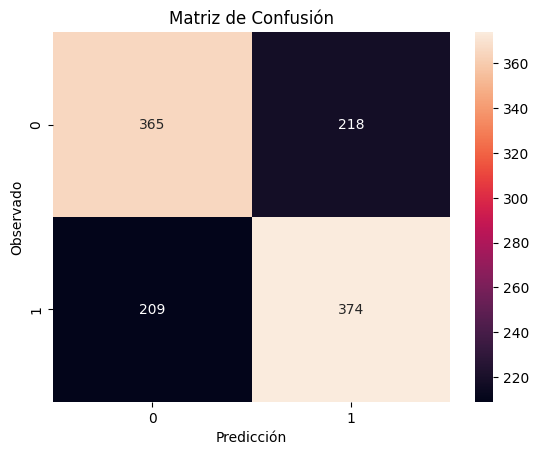

In [62]:
metricas_importante(y_test, y_pred)

### Regresión Lineal

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['Result Diff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar el modelo
lineal_model = LinearRegression()
lineal_model.fit(X_train, y_train)

# Predicciones
y_pred = lineal_model.predict(X_test)

# Evaluar el modelo
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 5.60
R²: 0.11


### Clasificación con PCA y SCV

In [64]:
from sklearn.decomposition import PCA

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['W/L']

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)

principal_Df = pd.DataFrame(principalComponents)

In [65]:
from sklearn.svm import SVC

X = principal_Df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# rbf = Gaussian Kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

RMSE:      0.61
Accuracy:  0.63
Recall:    0.62
Precision: 0.64
F score:   0.63
              precision    recall  f1-score   support

           0       0.63      0.64      0.64       583
           1       0.64      0.62      0.63       583

    accuracy                           0.63      1166
   macro avg       0.63      0.63      0.63      1166
weighted avg       0.63      0.63      0.63      1166



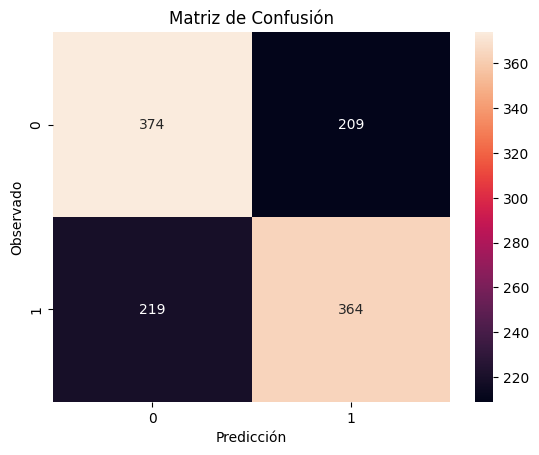

In [66]:
metricas_importante(y_test, y_pred)

### RandomForestRegressor

RMSE:      0.66
Accuracy:  0.57
Recall:    0.58
Precision: 0.57
F score:   0.57
              precision    recall  f1-score   support

           0       0.57      0.56      0.56       583
           1       0.57      0.58      0.57       583

    accuracy                           0.57      1166
   macro avg       0.57      0.57      0.57      1166
weighted avg       0.57      0.57      0.57      1166



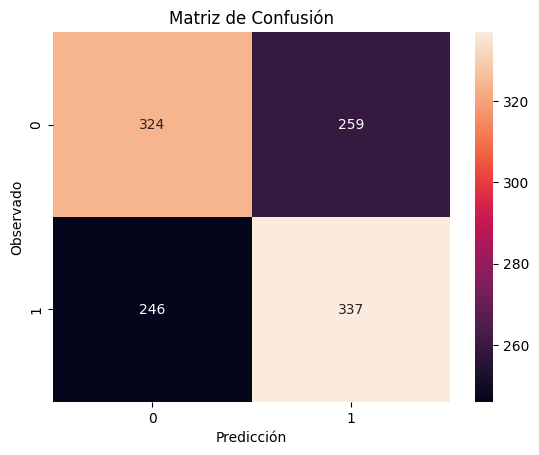

In [67]:
X = df.drop(columns=['W/L', 'Result Diff'])
y = df['W/L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

y_pred = [round(i) for i in y_pred]
metricas_importante(y_test, y_pred)

# 4. Ganador del Major

## Predictor entre dos equipos

In [68]:
def match_predictor(team_x: str, team_y: str):
    # Filtra los equipos consultados
    team_x_stats = df_teams[df_teams["Team"] == team_x]
    team_y_stats = df_teams[df_teams["Team"] == team_y]

    # Los juntamos en uno solo    
    team_stats = pd.merge(team_x_stats, team_y_stats, how="outer", on="Map Name")

    # Obtenemos los índices donde faltan stats para algún equipo
    team_x_nan_rows = team_stats[team_stats["Team_x"].isna()].index
    team_x_nan_rows = team_x_nan_rows.to_list()
    team_y_nan_rows = team_stats[team_stats["Team_y"].isna()].index
    team_y_nan_rows = team_y_nan_rows.to_list()

    # Le damos el formato utilizado para entrenarlo
    maps_encoded = pd.get_dummies(team_stats['Map Name'], prefix='Map')
    team_stats = pd.concat([team_stats, maps_encoded], axis=1)
    team_stats = team_stats.drop(columns=['Map Name'])

    team_stats = team_stats.drop(columns=["Team_x", "Team_y", "Group_x", "Group_y"])
    team_stats = team_stats.dropna()

    team_stats_columns = team_stats.columns[:22]
    team_stats_columns = team_stats_columns.append(team_stats.columns[26:-11])
    team_stats_columns

    scaler = StandardScaler()
    team_stats[team_stats_columns] = scaler.fit_transform(team_stats[team_stats_columns])

    # Predecimos las probabilidades de que team_x gane
    probs = lr_model.predict_proba(team_stats)[:, 1]
    probs = [round(i, 2) for i in probs]

    # Los equipo que no tienen stats para algún mapa los tomaremos como que pierden el mapa
    for i in team_x_nan_rows:
        if i in team_y_nan_rows:
            probs.insert(i, 0.5)
        else:
            probs.insert(i, 0)

    for i in team_y_nan_rows:
        if i in team_x_nan_rows:
            pass
        else:
            probs.insert(i, 1)

    # Crea un DataFrame con las probabilidades y retornamos
    df = pd.DataFrame({
        "Map": maps,
        team_x: probs
    })
    df[team_y] = 1 - df[team_x]
    return df

In [69]:
match_predictor("Natus Vincere", "FaZe")

,Map,Natus Vincere,FaZe
0,Ancient,0.42,0.58
1,Anubis,0.63,0.37
2,Dust2,0.84,0.16
3,Inferno,0.24,0.76
4,Mirage,0.43,0.57
5,Nuke,0.40,0.60
6,Vertigo,0.00,1.00


In [70]:
match_predictor("Natus Vincere", "Vitality")

,Map,Natus Vincere,Vitality
0,Ancient,1.00,0.00
1,Anubis,0.76,0.24
2,Dust2,0.65,0.35
3,Inferno,0.38,0.62
4,Mirage,0.48,0.52
5,Nuke,0.22,0.78
6,Vertigo,0.00,1.00
